# Exercise 6

## Predict rating using LSTM


In [1]:
import pandas as pd

In [2]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [3]:
dataTraining.shape

(7895, 5)

In [4]:
plots = dataTraining['plot']
#Devuelve 1 o 0 comparando columna 'rating' con su media para cada elemento indicando: (1) mayor o igual que la media y (0) menor que media.
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [5]:
plots

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [6]:
y

3107    1
900     0
6724    1
4704    1
2582    1
       ..
8417    0
1592    0
1723    0
7605    1
215     1
Name: rating, Length: 7895, dtype: int64

# Exercise 6.1

- Remove stopwords
- Lowercase
- split the text in words
- pad_sequences

In [7]:
!pip install livelossplot --quiet

In [8]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import r2_score, roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, Dropout
from keras.utils import pad_sequences, plot_model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from livelossplot import PlotLossesKeras
%matplotlib inline
import re

2023-09-22 21:46:10.049085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
nltk.download('stopwords')
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crubiano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Añadir stopwords adicionales que se consideren necesarios
stopwords_adicionales = ["is", "the","huw","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
stopwords_en.extend(stopwords_adicionales)


In [11]:
#Creacion de una función para poder realizar un preprocesamiento del plot.
def preprocesamiento(text):
  #Convertir todo a lowercase
  text = text.str.lower()
  # Eliminar stopwords
  text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_en]))
  # Quitar caracteres que no sean letras (Se eliminan caracteres especiales y numeros)
  text = text.apply(lambda x: ' '.join([re.sub(r'[^a-zA-Z]', '', word) for word in x.split()]))
  #Quitarle espacios en blanco
  text = text.apply(lambda x: ' '.join(x.split()))

  return text


In [12]:
#Se ejecuta función de Preprocesamiento sobre plot
dataTraining['plot_ppr'] = preprocesamiento(dataTraining['plot'])

In [13]:
import pandas as pd

# Calcular la cantidad de palabras en la columna de texto
dataTraining['qty_palabras'] = dataTraining['plot_ppr'].str.split().apply(len)

In [14]:
# Mostrar el DataFrame resultante
max_qty_palabras = dataTraining['qty_palabras'].max()
print(max_qty_palabras)

820


In [15]:
unique_words = []
for text in dataTraining['plot_ppr']:
    unique_words.extend(text.split())
unique_words = set(unique_words)

In [16]:
vocabulary = {word: idx + 1 for idx, word in enumerate(unique_words)}

In [17]:
#Crear un vocabulario asignando a cada palabra un valor único
#vocabulary = {word: idx + 1 for idx, word in enumerate(set(word for plot in dataTraining['plot_ppr'] for word in plot))}

In [18]:
#X = dataTraining['plot_ppr'] .tolist()

In [19]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
#voc = set(''.join(X))
#vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [20]:
#Crear un vocabulario asignando a cada palabra un valor único
#vocabulary = {word: idx + 1 for idx, word in enumerate(set(word for plot in dataTraining['plot_ppr'] for word in plot))}

In [21]:
X = dataTraining['plot_ppr'] .tolist()

In [22]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
#voc = set(''.join(X))
#vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [23]:
len(vocabulary)

38520

In [24]:
#print(vocabulary)

In [25]:
dataTraining.dtypes

year              int64
title            object
plot             object
genres           object
rating          float64
plot_ppr         object
qty_palabras      int64
dtype: object

In [26]:
# Max len
max_len = 810 #102
X = [x[:max_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [27]:
len(X)

7895

In [28]:
X_pad = pad_sequences(X, maxlen=max_len)

In [29]:
X_pad

array([[    0,     0,     0, ..., 30752, 10410, 36649],
       [    0,     0,     0, ..., 36649,  3565, 10410],
       [    0,     0,     0, ..., 30752,  3565,  5070],
       ...,
       [    0,     0,     0, ...,  3565, 10410,  3565],
       [    0,     0,     0, ...,  3565,  3565,  3565],
       [    0,     0,     0, ...,  5070, 30752, 10410]], dtype=int32)

In [30]:
 X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.33, random_state=42)

# Exercise 6.2

Create a SimpleRNN neural network to predict the rating of a movie

Calculate the testing set accuracy

In [31]:
model_RNN = Sequential()
#Se utiliza una capa de Embedding para convertir los números enteros en vectores de embedding (Esto captura mejor las relaciones semánticas y las similitudes entre palabras)
#model.add(Embedding(input_dim=len(vocabulary) + 1, output_dim=32, input_length=max_sequence_length))
#model.add(SimpleRNN(64, activation='relu'))
#model.add(Dense(1, activation='linear'))  # Capa de salida para la predicción del rating
model_RNN.add(Embedding(input_dim=len(vocabulary) + 1, output_dim=64, input_length=max_len))
model_RNN.add(Dropout(0.5))
model_RNN.add(SimpleRNN(32, activation='relu'))
model_RNN.add(Dropout(0.5))
model_RNN.add(Dense(1, activation='sigmoid'))  # Capa de salida para la predicción del rating
#mean_squared_error función de pérdida comúnmente utilizada para problemas de regresión
model_RNN.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_RNN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 810, 64)           2465344   
                                                                 
 dropout (Dropout)           (None, 810, 64)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2468481 (9.42 MB)
Trainable params: 2468481 (9.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


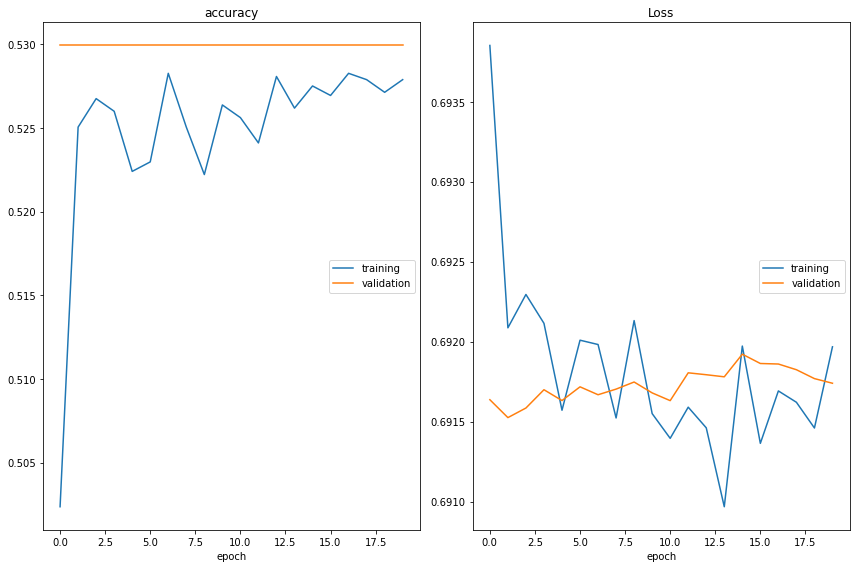

accuracy
	training         	 (min:    0.502, max:    0.528, cur:    0.528)
	validation       	 (min:    0.530, max:    0.530, cur:    0.530)
Loss
	training         	 (min:    0.691, max:    0.694, cur:    0.692)
	validation       	 (min:    0.692, max:    0.692, cur:    0.692)
42/42 [==============================] - 8s 184ms/step - loss: 0.6920 - accuracy: 0.5279 - val_loss: 0.6917 - val_accuracy: 0.5299


In [32]:
#Entrenar el modelo
batch_size = 128
epochs = 20

history = model_RNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test),callbacks=[PlotLossesKeras()])

In [33]:
# Calcular la precisión en el conjunto de prueba
test_loss, test_accuracy_RNN = model_RNN.evaluate(X_test, y_test)

print("Loss en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy_RNN)

82/82 [==============================] - 2s 22ms/step - loss: 0.6917 - accuracy: 0.5299
Loss en el conjunto de prueba: 0.6917400360107422
Precisión en el conjunto de prueba: 0.5299309492111206


# Exercise 6.3

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [34]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(vocabulary) + 1, 64, input_length=max_len))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(LSTM(32))
#model_lstm.add(Dropout(0.5))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 810, 64)           2465344   
                                                                 
 dropout_2 (Dropout)         (None, 810, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2477793 (9.45 MB)
Trainable params: 2477793 (9.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


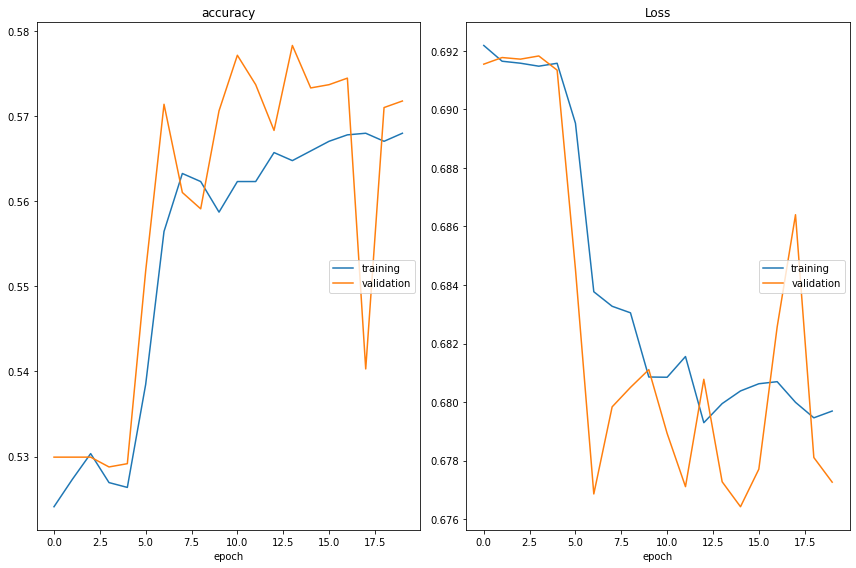

accuracy
	training         	 (min:    0.524, max:    0.568, cur:    0.568)
	validation       	 (min:    0.529, max:    0.578, cur:    0.572)
Loss
	training         	 (min:    0.679, max:    0.692, cur:    0.680)
	validation       	 (min:    0.676, max:    0.692, cur:    0.677)
42/42 [==============================] - 28s 647ms/step - loss: 0.6797 - accuracy: 0.5680 - val_loss: 0.6773 - val_accuracy: 0.5718


In [35]:
#Entrenar el modelo
batch_size = 128
epochs = 20

history = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test),callbacks=[PlotLossesKeras()])

In [36]:
# Calcular la precisión en el conjunto de prueba
test_loss, test_accuracy_LSTM = model_LSTM.evaluate(X_test, y_test)

print("Loss en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy_LSTM)

82/82 [==============================] - 4s 45ms/step - loss: 0.6773 - accuracy: 0.5718
Loss en el conjunto de prueba: 0.6772620677947998
Precisión en el conjunto de prueba: 0.5717574954032898


# Exercise 6.4

Create a GRU neural network to predict the rating of a movie

Calculate the testing set accuracy

In [37]:
# Crear un modelo Sequential
model_GRU = Sequential()
# Agregar una capa de Embedding para convertir secuencias de enteros en vectores de embedding
#vocab_size = len(vocabulary) + 1  # El tamaño del vocabulario más uno para el valor de relleno (padding)
#embedding_dim = 100  # Tamaño de los vectores de embedding
model_GRU.add(Embedding(input_dim=len(vocabulary) + 1, output_dim=810, input_length=max_len))
model_GRU.add(Dropout(0.5))
model_GRU.add(GRU(32, activation='relu'))
#model_lstm.add(Dropout(0.3))
model_GRU.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con el optimizador Adam y la función de pérdida binary_crossentropy para problemas de clasificación binaria
model_GRU.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_GRU.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 810, 810)          31202010  
                                                                 
 dropout_3 (Dropout)         (None, 810, 810)          0         
                                                                 
 gru (GRU)                   (None, 32)                81024     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31283067 (119.34 MB)
Trainable params: 31283067 (119.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


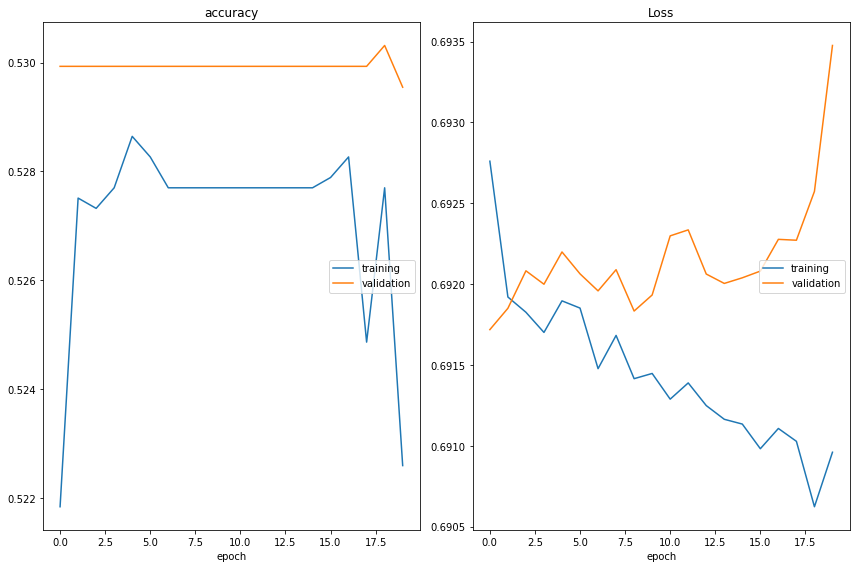

accuracy
	training         	 (min:    0.522, max:    0.529, cur:    0.523)
	validation       	 (min:    0.530, max:    0.530, cur:    0.530)
Loss
	training         	 (min:    0.691, max:    0.693, cur:    0.691)
	validation       	 (min:    0.692, max:    0.693, cur:    0.693)
42/42 [==============================] - 107s 3s/step - loss: 0.6910 - accuracy: 0.5226 - val_loss: 0.6935 - val_accuracy: 0.5295


In [38]:
#Entrenar el modelo
batch_size = 128
epochs = 20

history = model_GRU.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test),callbacks=[PlotLossesKeras()])

In [39]:
# Calcular la precisión en el conjunto de prueba
test_loss, test_accuracy_GRU = model_GRU.evaluate(X_test, y_test)

print("Loss en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy_GRU)

82/82 [==============================] - 20s 241ms/step - loss: 0.6935 - accuracy: 0.5295
Loss en el conjunto de prueba: 0.6934758424758911
Precisión en el conjunto de prueba: 0.5295472145080566


#Comparación Modelos

In [40]:
#Comparación Accuracy de Modelos en Test
print('Datos Test RNN  ->  ',test_accuracy_RNN)  #Accuracy RNN
print('Datos Test LSTM ->  ',test_accuracy_LSTM) #Accuracy LSTM
print('Datos Test GRU  ->  ',test_accuracy_GRU)  #Accuracy GRU

Datos Test RNN  ->   0.5299309492111206
Datos Test LSTM ->   0.5717574954032898
Datos Test GRU  ->   0.5295472145080566
